In [1]:
import dask
dask.__version__

'2021.05.0'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import dask
import time
import shutil
import warnings
import xarray as xr

import matplotlib.pyplot as plt
from fastjmd95 import rho
import fastjmd95

assert fastjmd95.__version__ >= "0.2.1"

from multiprocessing.pool import ThreadPool
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

from xgcm import Grid
from fastprogress.fastprogress import progress_bar

from xarrayutils.file_handling import (
    write,
    maybe_create_folder,
    file_exist_check,
    temp_write_split,
)
from xarrayutils.utils import remove_bottom_values


from aguadv_omz_busecke_2021.vertical_transformation import (
    xgcm_transform_wrapper as transform_wrapper,
)

import sys
sys.path.append("../../cmip6_omz")

from datasets import woa13
from omz_tools import (
    volume_consistency_checks,
    omz_thickness,  
)

from aguadv_omz_busecke_2021.utils import print_html
from aguadv_omz_busecke_2021.preprocessing import (
    mixed_layer_wrapper,
    save_and_reload_rechunker,
    preprocessing_wrapper,
    strip_encoding,
)
from aguadv_omz_busecke_2021.omz_tools import (
    plot_omz_results,
    mask_basin,
)


from aguadv_omz_busecke_2021.cmip6_stash import (
    detrend,
    construct_cfdate,
    _get_calendar,
    cmip6_dataset_id,
    combined_preprocessing,
    load_single_datasets,
    nested_dataset_wrapper,
    match_and_detrend,
    combine_grid_labels,
    parse_metrics,
)

dask.config.set(pool=ThreadPool(32))

In [3]:
def transform_wrapper_again(
    ds_in,
    intensive_vars=[
        "thetao",
        "o2",
        "so",
        "agessc",
    ],
    new_sigma = False
):
    # alternate name: transform mean wrapper
    # sigma_bins
    if new_sigma == True:
        sigma_bins = np.array([0, 23.0, 24.5, 25.5, 26.5, 26.65, 26.7, 27.4, 27.65, 27.8, 100])
    else:
        sigma_bins = np.array([0, 24.5, 26.5, 27.65, 100])

    # define variables to be averaged (intensive quantities)
    intensive_vars = [
        "thetao",
        "o2",
        "so",
        "agessc",
    ]  # add 'uo', 'agessc' etc?

    intensive_vars = [v for v in intensive_vars if v in ds_in.data_vars]

    for iv in intensive_vars:
        dz = (xr.ones_like(ds_in[iv]) * ds_in.dz_t).where(~np.isnan(ds_in[iv]))
        ds_in[iv] = ds_in[iv] * dz

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ds_out = transform_wrapper(
            ds_in,
            extensive_vars=["omz_thickness"] + intensive_vars,
            target=sigma_bins,
        )

    # reconvert the same variables
    dz = ds_out.dz_t
    for iv in intensive_vars:
        ds_out[iv] = ds_out[iv] / dz
    return ds_out

In [4]:
foldername = "density_remapping_obs"
#ofolder = maybe_create_folder(f"/tigress/GEOCLIM/LRGROUP/samjd/global_omz/{foldername}")
ofolder = maybe_create_folder(f"../../data/{foldername}")

/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../../data/density_remapping_obs does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


# First, Let's try just applying the aguadv_omz_busecke_2021 framework globally

In [6]:
woa = woa13().drop('time')
woa['sigma_0'] = (fastjmd95.rho(woa.so, woa.thetao, 0) - 1000)
woa = woa.rename({'thkcello':'dz_t'})
woa = woa.chunk({'lev':-1,'x':180})
woa['omz_thickness'] = omz_thickness(woa)#, o2_bins=o2_bins)

woa_sigma = transform_wrapper_again(woa, intensive_vars=[va for va in woa.data_vars if va not in ['omz_thickness']])

# confirm that the volume is conserved
with ProgressBar():
    vol_sigma = (woa_sigma.omz_thickness * woa_sigma.areacello).sum(['x','y','sigma_0']).load()
    vol_z = (woa.omz_thickness * woa.areacello).sum(['x', 'y', 'lev']).load()
    
assert (((vol_z - vol_sigma)/vol_z*100)<1.0).all() #failed 0.5, change to 1.

fname = ofolder.joinpath('woa13.nc')
woa_sigma = write(woa_sigma, fname, overwrite=True)

../../cmip6_omz/datasets.py:31: UserWarning: No bounds found for lon and lat. Reconstructing with a very simplified method. Check results carefully.
  warnings.warn(


[########################################] | 100% Completed |  1min 19.6s
[########################################] | 100% Completed |  1.7s
Removing file ../../data/density_remapping_obs/woa13.nc
$ Saving 0.52670322GB to ../../data/density_remapping_obs/woa13.nc


/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


$ Reloading file


In [34]:
woa_pacific = mask_basin(woa_sigma, region='Pacific')
woa_atlantic = mask_basin(woa_sigma, region='Atlantic')
woa_indian = mask_basin(woa_sigma, region='Indian')

/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_geography_marine_polys.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [120]:
#look at the preset masks
#woa_sigma.isel(sigma_0=2).o2.plot(robust = True)
#woa_pacific.isel(sigma_0=2).o2.plot(robust = True)
#woa_atlantic.isel(sigma_0=2).o2.plot(robust = True)
#woa_indian.isel(sigma_0=2).o2.plot(x = 'lon', y = 'lat', robust = True)

In [117]:
#want 30S (y=121) to 30N (y = 362), o2 = 80 \mu mol/kg
woa_pac = woa_pacific.isel(o2_bin = 5, y = list(range(121,362)))
omz_thick_pac = np.nanmean(woa_pac.omz_thickness, axis = 1)
woa_atl = woa_atlantic.isel(o2_bin = 5, y = list(range(121,362)))
omz_thick_atl = np.nanmean(woa_atl.omz_thickness, axis = 1)
woa_AS = woa_indian.isel(o2_bin = 5, y = list(range(121,362)), x = list(range(0, 222)))
omz_thick_AS = np.nanmean(woa_AS.omz_thickness, axis = 1)
woa_BB = woa_indian.isel(o2_bin = 5, y = list(range(121,362)), x = list(range(222,400)))
omz_thick_BB = np.nanmean(woa_BB.omz_thickness, axis = 1)

<ipython-input-117-adcea3620ca4>:9: RuntimeWarning: Mean of empty slice
  omz_thick_BB = np.nanmean(woa_BB.omz_thickness, axis = 1)


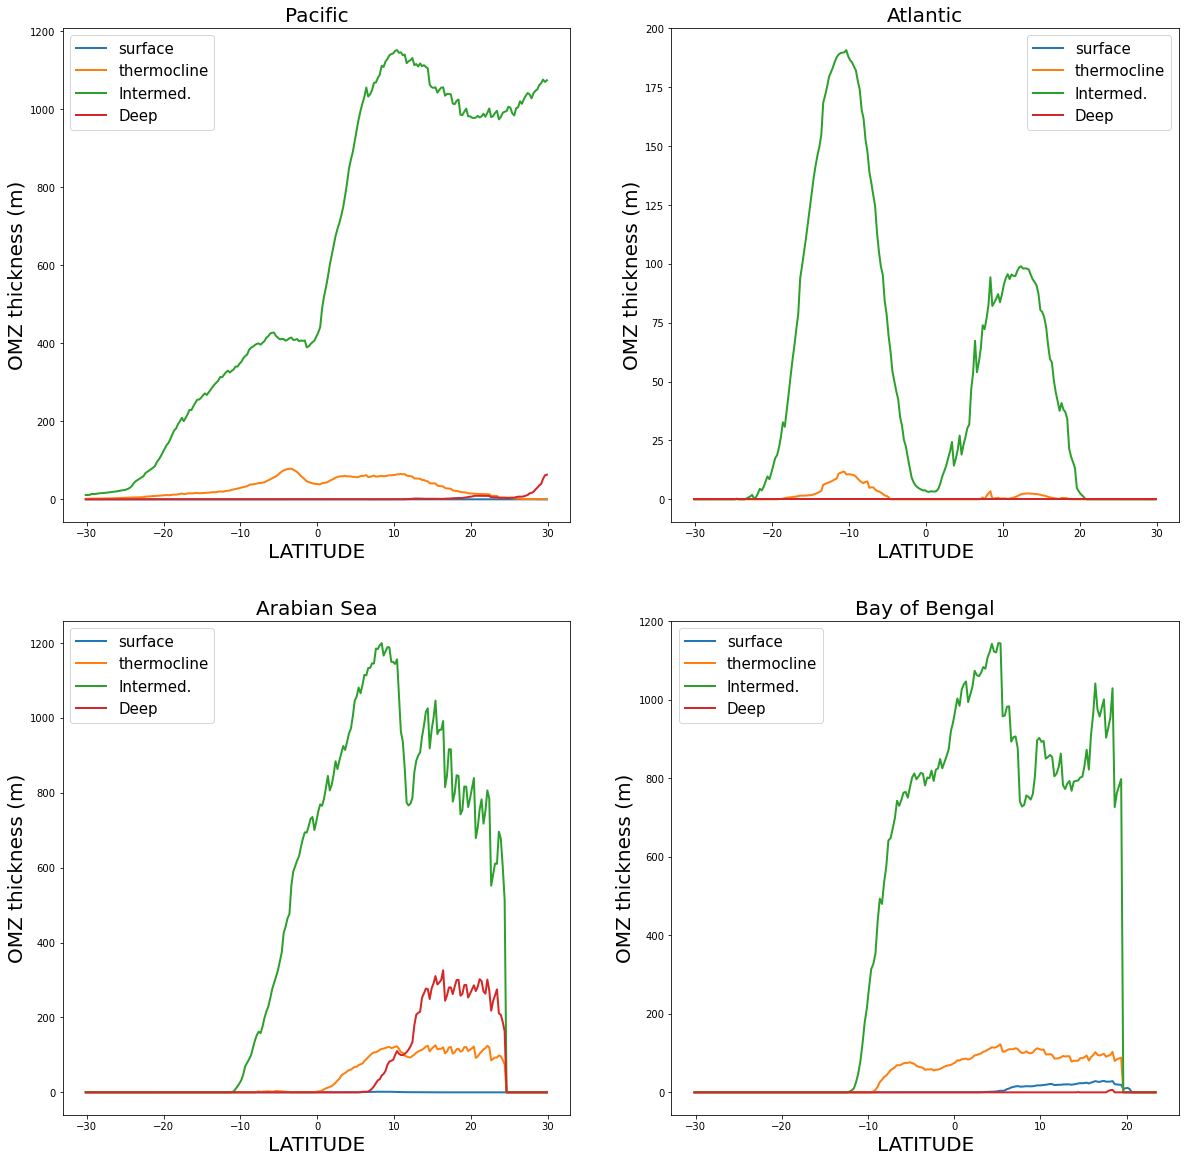

In [119]:
basins = ['Pacific', 'Atlantic', 'Arabian Sea', 'Bay of Bengal']
labels = ['surface', 'thermocline', 'Intermed.', 'Deep']
lats = [woa_pac.lat[0], woa_atl.lat[0], woa_AS.lat[0], woa_BB.lat[0]]
omz_thick = [omz_thick_pac, omz_thick_atl, omz_thick_AS, omz_thick_BB]
fig, axes = plt.subplots(2,2,figsize = (20,20))
for j, ax in enumerate(axes.flat):
    for i in range(len(labels)):
        ax.set_title(basins[j], fontsize = 20)
        ax.plot(lats[j], omz_thick[j][:,i], label = labels[i], linewidth = 2)
        ax.set_xlabel('LATITUDE', fontsize = 20)
        ax.set_ylabel('OMZ thickness (m)', fontsize = 20)
        #ax.set_ylim(.1, 5000)
        #ax.set_yscale('log')
        ax.legend(fontsize = 15)

# Now, let's try applying our idea for a global framework using stratification

In [5]:
woa = woa13().drop('time')
woa['sigma_0'] = (fastjmd95.rho(woa.so, woa.thetao, 0) - 1000)
woa = woa.rename({'thkcello':'dz_t'})
woa = woa.chunk({'lev':-1,'x':180})
woa['omz_thickness'] = omz_thickness(woa)#, o2_bins=o2_bins)

woa_sigma_glob = transform_wrapper_again(woa, intensive_vars=[va for va in woa.data_vars if va not in ['omz_thickness']], 
                                   new_sigma = True)

# confirm that the volume is conserved
with ProgressBar():
    vol_sigma = (woa_sigma_glob.omz_thickness * woa_sigma_glob.areacello).sum(['x','y','sigma_0']).load()
    vol_z = (woa.omz_thickness * woa.areacello).sum(['x', 'y', 'lev']).load()
    
assert (((vol_z - vol_sigma)/vol_z*100)<1.0).all() #failed 0.5, change to 1.

fname = ofolder.joinpath('woa13_global.nc')
woa_sigma_glob = write(woa_sigma_glob, fname, overwrite=True)

../../cmip6_omz/datasets.py:31: UserWarning: No bounds found for lon and lat. Reconstructing with a very simplified method. Check results carefully.
  warnings.warn(


[########################################] | 100% Completed |  1min 20.0s
[########################################] | 100% Completed |  1.6s
Removing file ../../data/density_remapping_obs/woa13_global.nc
$ Saving 1.298082564GB to ../../data/density_remapping_obs/woa13_global.nc


/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/home/samjd/anaconda3/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


$ Reloading file


In [157]:
#woa_sigma_global = xr.open_dataset('../../data/density_remapping_obs/woa13_global.nc', decode_times = False)

In [6]:
woa_sigma_glob

<xarray.Dataset>
Dimensions:             (bnds: 2, o2_bin: 9, sigma_0: 10, x: 1440, y: 720)
Coordinates: (12/13)
    crs                 int32 ...
  * y                   (y) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x                   (x) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    lon                 (x, y) float32 ...
    lat                 (x, y) float32 ...
    areacello           (x, y) float32 ...
    ...                  ...
  * o2_bin              (o2_bin) int64 5 10 20 40 60 80 100 120 140
    climatology_bounds  (bnds) float32 ...
    lev                 (y, x, sigma_0) float64 ...
    dz_t                (y, x, sigma_0) float64 ...
    lev_bounds          (bnds, y, x, sigma_0) float64 ...
    sigma_0_bounds      (bnds, sigma_0) float64 ...
Dimensions without coordinates: bnds
Data variables:
    so                  (y, x, sigma_0) float64 ...
    thetao              (y, x, sigma_0) float64 ...
    o2                  (y, x, sigma_0) float64 ...
    aou                 (y, x, sigma_0) float64 ...
    po4                 (y, x, sigma_0) float64 ...
    no3                 (y, x, sigma_0) float64 ...
    o2sat               (y, x, sigma_0) float64 ...
    omz_thickness       (o2_bin, y, x, sigma_0) float32 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2013 version 2 : sea_w...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, J. I. Antonov...
    institution:                     National Oceanographic Data Center(NODC)
    comment:                         global climatology as part of the World ...
    ...                              ...
    nodc_template_version:           NODC_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA13/pr_wo...
    date_created:                    2011-09-28 
    date_modified:                   2011-09-28

In [7]:
woa_pacific2 = mask_basin(woa_sigma_glob, region='Pacific')
woa_atlantic2 = mask_basin(woa_sigma_glob, region='Atlantic')
woa_indian2 = mask_basin(woa_sigma_glob, region='Indian')

In [8]:
#want 30S (y=121) to 30N (y = 362)
woa_pac = woa_pacific2.isel(o2_bin = 5, y = list(range(121,362)))
omz_thick_pac = np.nanmean(woa_pac.omz_thickness, axis = 1)
woa_atl = woa_atlantic2.isel(o2_bin = 5, y = list(range(121,362)))
omz_thick_atl = np.nanmean(woa_atl.omz_thickness, axis = 1)
woa_AS = woa_indian2.isel(o2_bin = 5, y = list(range(121,362)), x = list(range(0, 222)))
omz_thick_AS = np.nanmean(woa_AS.omz_thickness, axis = 1)
woa_BB = woa_indian2.isel(o2_bin = 5, y = list(range(121,362)), x = list(range(222,400)))
omz_thick_BB = np.nanmean(woa_BB.omz_thickness, axis = 1)

<ipython-input-8-04a86c397c96>:9: RuntimeWarning: Mean of empty slice
  omz_thick_BB = np.nanmean(woa_BB.omz_thickness, axis = 1)


In [9]:
#[0, 24.5, 25.5, 26.5, 26.65, 26.7, 27.25, 27.65, 27.8, 100]
sigma_transform_inds = {
    'Pacific':['0:2', '2:4', '4:8', '8:'],
    'Atlantic': ['0:3', '3:5', '5:7', '7:'],
    'Arabian Sea': ['0:2', '2:6', '6:9', '9'],
    'Bay of Bengal': ['0', '1:6', '6:8', '8:']
}

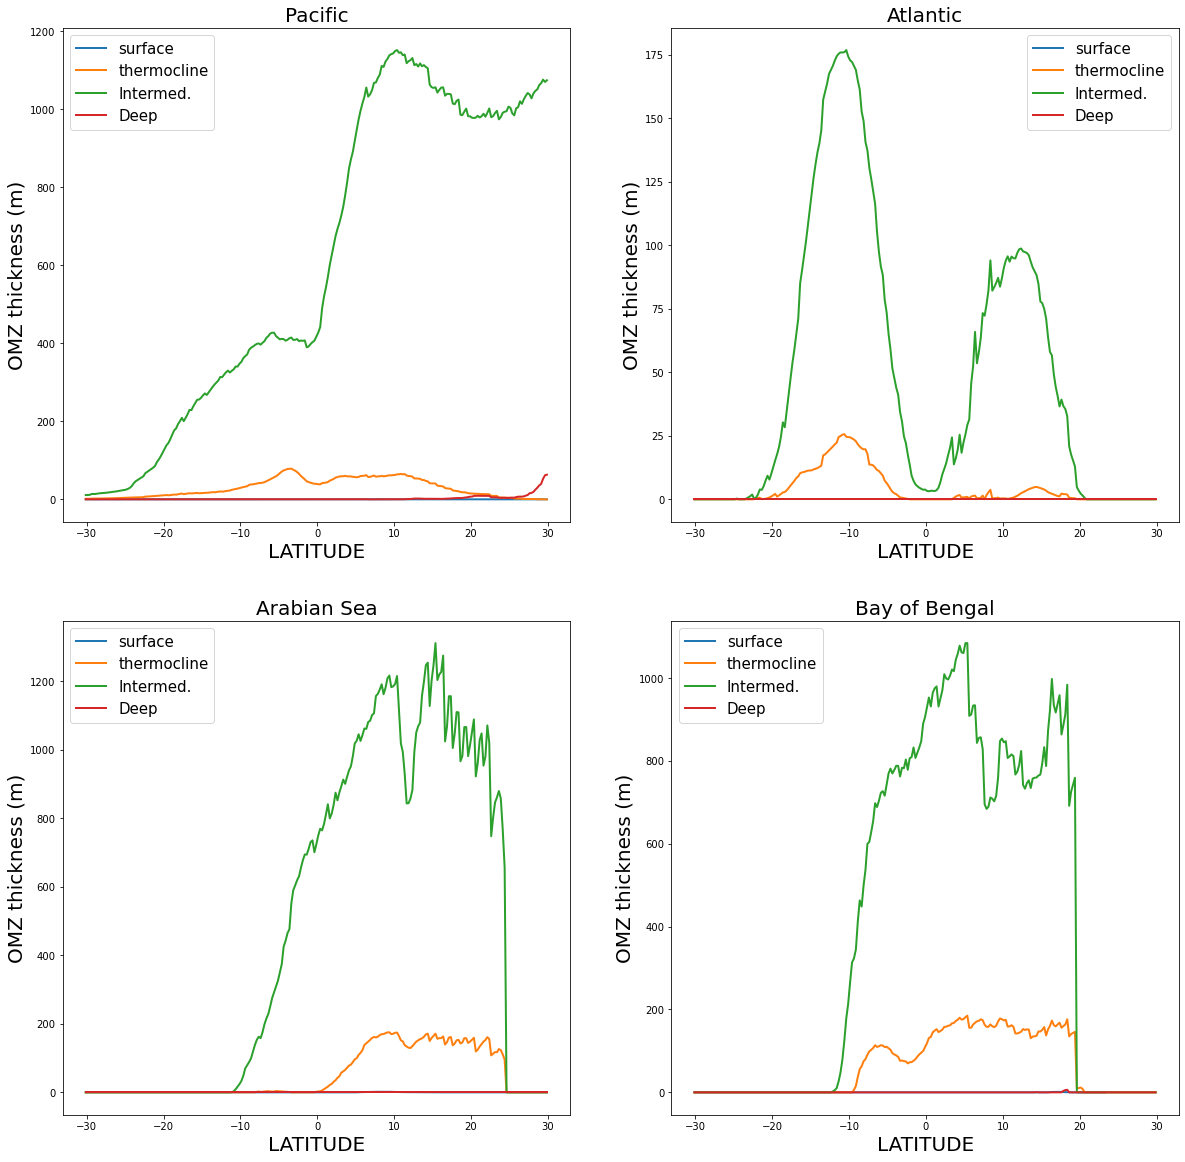

In [12]:
%matplotlib inline
basins = ['Pacific', 'Atlantic', 'Arabian Sea', 'Bay of Bengal']
labels = ['surface', 'thermocline', 'Intermed.', 'Deep']
lats = [woa_pac.lat[0], woa_atl.lat[0], woa_AS.lat[0], woa_BB.lat[0]]
omz_thick = [omz_thick_pac, omz_thick_atl, omz_thick_AS, omz_thick_BB]
fig, axes = plt.subplots(2,2,figsize = (20,20))
for j, ax in enumerate(axes.flat):
    for i in range(len(labels)):
        inds = sigma_transform_inds[basins[j]][i]
        if ':' in inds:
            curve = eval(f'np.nansum(omz_thick[j][:,{inds}], axis = 1)')
        else:
            curve = eval(f'omz_thick[j][:,{inds}]')
        ax.set_title(basins[j], fontsize = 20)
        ax.plot(lats[j], curve, label = labels[i], linewidth = 2)
        ax.set_xlabel('LATITUDE', fontsize = 20)
        ax.set_ylabel('OMZ thickness (m)', fontsize = 20)
        #ax.set_ylim(.1, 5000)
        #ax.set_yscale('log')
        ax.legend(fontsize = 15)

# Notes:

This global framework achieves our goal. Namely to flatten out the 'surface' and 'Deep' curves in the above plot. The trade off is that is approximately doubles the size of the preprocessed file. Which could create issues when using this same treatment on annually resolved model data.   